In [ ]:
# Does reflected light calculations for GLINT

# 2024 Mar 24 by E.S.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from expecto import get_spectrum
from astropy.visualization import quantity_support

In [87]:
# read in exoplanets table

df = pd.read_csv('./data/exoplanets_2024_03_23.csv', header=96)
df = df.where(df['pl_controv_flag'] == 0) # remove controversials
df_avg = df.groupby(['pl_name','discoverymethod'], as_index=False).mean()  # Group by 'pl_name' and calculate the mean

/var/folders/8y/ztvmc5ys1pn64bjywt1qp4k40000gs/T/ipykernel_12176/3060826348.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_avg = df.groupby(['pl_name','discoverymethod'], as_index=False).mean()  # Group by 'pl_name' and calculate the mean


In [25]:
def flux_ratio_refl(Ag, Rp, a, ang_phase):
    '''
    Notation from Seager, Eqn. 3.49

    Ag: geometric albedo (fcn of wavelength) [1]
    Rp: Radius of planet [RJ]
    a: semimajor axis [AU]
    ang_phase: phase angle (often notated as alpha; angle star-exoplanet-us) [rad]
    '''

    RJ_per_AU = 2092.51

    # Lambert sphere phase law
    # (see Traub and Oppenheimer 'Direct Imaging of Exoplanets,' Eqn. 14; Madhusudan and Burrows 2012 ApJ 747:25, Eqn. 33)
    phi = (1./np.pi) * ( np.sin(ang_phase) + (np.pi - ang_phase) * np.cos(ang_phase) )

    flux_ratio = Ag * phi * np.power(np.divide(Rp, a)/RJ_per_AU, 2)

    return flux_ratio

In [88]:
contrast_reflected_planets = flux_ratio_refl(Ag = 0.45, Rp = df_avg['pl_radj'], a = df_avg['pl_orbsmax'], ang_phase = np.pi/2)

In [93]:
df_avg['discoverymethod'].unique()

array(['Radial Velocity', 'Imaging', 'Eclipse Timing Variations',
       'Transit', 'Transit Timing Variations', 'Astrometry',
       'Disk Kinematics', 'Microlensing', 'Orbital Brightness Modulation',
       'Pulsation Timing Variations', 'Pulsar Timing'], dtype=object)

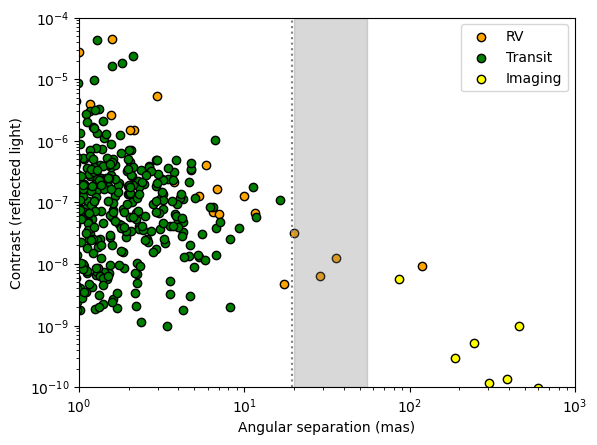

In [128]:
iwa_rough_asec = ((1.55e-6)/(2 * 8.25)) * 206265
iwa_rough_mas = 1e3 * iwa_rough_asec

plt.scatter(1000.*angle_array, contrast_reflected_planets.where(df_avg['discoverymethod']=='Radial Velocity'), c='orange', edgecolors='black', label='RV')
plt.scatter(1000.*angle_array, contrast_reflected_planets.where(df_avg['discoverymethod']=='Transit'), c='green', edgecolors='black', label='Transit')
plt.scatter(1000.*angle_array, contrast_reflected_planets.where(df_avg['discoverymethod']=='Imaging'), c='yellow', edgecolors='black', label='Imaging')

# Annotate markers with 'pl_name' values
'''
for i, name in enumerate(df_avg['pl_name']):
    x_value = 1000. * angle_array[i]
    if x_value > 15:
        plt.annotate(name, (x_value, contrast_reflected_planets[i]), textcoords="offset points", xytext=(0,-30), arrowprops=dict(facecolor='black', shrink=0.01), ha='center')
'''
        
'''
# other detection methods
plt.scatter(1000.*angle_array, contrast_reflected_planets.where(df_avg['discoverymethod']=='Transit Timing Variations'), c='blue', edgecolors='black', label='TTV')
plt.scatter(1000.*angle_array, contrast_reflected_planets.where(df_avg['discoverymethod']=='Eclipse Timing Variations'), c='black', edgecolors='black', label='ETV')
plt.scatter(1000.*angle_array, contrast_reflected_planets.where(df_avg['discoverymethod']=='Astrometry'), c='black', edgecolors='brown', label='Astrometry')
plt.scatter(1000.*angle_array, contrast_reflected_planets.where(df_avg['discoverymethod']=='Orbital Brightness Modulation'), c='white', edgecolors='brown', label='OBM')
plt.scatter(1000.*angle_array, contrast_reflected_planets.where(df_avg['discoverymethod']=='Disk kinematics'), c='purple', edgecolors='brown', label='DK')
plt.scatter(1000.*angle_array, contrast_reflected_planets.where(df_avg['discoverymethod']=='Microlensing'), c='purple', edgecolors='brown', label='Microlensing')
'''
plt.xlabel('Angular separation (mas)')
plt.ylabel('Contrast (reflected light)')

plt.xlim([1, 1e3])
plt.ylim([1e-10, 1e-4])
plt.axvline(x=iwa_rough_mas, linestyle=':', color='gray')
plt.fill_betweenx([plt.ylim()[0], plt.ylim()[1]], 20, 55, color='gray', alpha=0.3)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

In [112]:
iwa_rough_mas

1.937640909090909e-05

In [ ]:
#def refl_frac_phase(phase_angle_deg):
#    phase_rad = phase_angle_deg / 180 * np.pi
#    frac = 1/np.pi * (np.sin(phase_rad) + (np.pi-phase_rad)*np.cos(phase_rad))
#    return frac

In [36]:
def get_photnoise_contrast(del_mag, contrast, verbose=True, null_depth=1):
    '''
    del_mag: mag_star - mag_zero = mag_star - 0 (effectively, the magnitude of the star)
    contrast: planet/star contrast
    '''

    # wavelength = 1.6  # microns
    bandwidth = 0.35  # microns
    pup_diam = 6 # m
    pupil_fraction = 0.8 # TBD: change this to equivalent of GLINT mask

    framerate = 1000 # Hz
    read_noise = 0.4 #e-
    dark_noise = 0.03*3500 # e-/px/s
    QE = 0.8
    int_time = 3600 #s
    num_outfibs = 12 # IS THIS RIGHT? ALL WAVEGUIDE OUTPUTS? TBD: modify this based on splitting between the waveguides
    num_specchans = 30 # R~100 over H band # TBD: update val
    num_pix = num_outfibs * num_specchans # TBD: make more realistic (Gaussian profile of spectrum, etc.)

    # Rule of thumb: 0 mag at H = 1e10 ph/um/s/m^2
    # e.g. An H=5 object gives 1 ph/cm^2/s/A
    mag0flux = 1e10  # ph/um/s/m^2 # TBD: update for values at other bandpasses
    star_flux = mag0flux* np.power(10.,-0.4*del_mag)

    # Collecting area:
    pupil_area_passed = np.pi * np.power(pup_diam/2, 2) * pupil_fraction
    injection_efficiency = 0.8
    instr_throughput = 0.5

    #refl_frac = refl_frac_phase(phase_angle_deg)

    n_ints = int_time * framerate
    dark_noise_photons = (dark_noise * int_time) / QE
    read_noise_tot = read_noise * np.sqrt(num_pix) * np.sqrt(n_ints)
    read_noise_photons = read_noise_tot / QE
    star_photons = star_flux * injection_efficiency * instr_throughput * \
                   pupil_area_passed * bandwidth * int_time
    star_snr = star_photons / np.sqrt(read_noise_photons**2 + dark_noise_photons**2)

    planet_flux = star_photons * contrast
    planet_snr = planet_flux / np.sqrt(star_photons + read_noise_photons ** 2 + dark_noise_photons**2)
    nulled_planet_snr = planet_flux / np.sqrt(star_photons * null_depth + read_noise_photons ** 2 +
                                              dark_noise_photons**2)

    if verbose:
        print("Stellar photons: %.3g" % star_photons)
        print('S/N of star: %f' % star_snr)
        print('No-nulling S/N of planet: %f' % planet_snr)
        print('Nulled S/N of planet: %f' % nulled_planet_snr)

    return nulled_planet_snr

In [41]:
# contrasts at variety of orbital radii (says nothing about S/N)
start_sep = 5e-3
end_sep = 1.5  # in au
num_points = 1000

Ag_earth = 0.434 # Jupiter: 0.538; Earth: 0.434
Rp_earth = 0.091 # Jupiter: 1; Earth: 0.091 (approx)
a_earth = 1. # Jupiter: 5.2034; Earth: 1

a_array = np.linspace(start_sep, end_sep, num_points) # different planet orbital radii

flux_ratio_alph_0 = flux_ratio_refl(Ag=Ag_earth, Rp=Rp_earth, a=a_array, ang_phase=0)
flux_ratio_alph_0pt3pi = flux_ratio_refl(Ag=Ag_earth, Rp=Rp_earth, a=a_array, ang_phase=0.3*np.pi)
flux_ratio_alph_0pt5pi = flux_ratio_refl(Ag=Ag_earth, Rp=Rp_earth, a=a_array, ang_phase=np.pi/2)

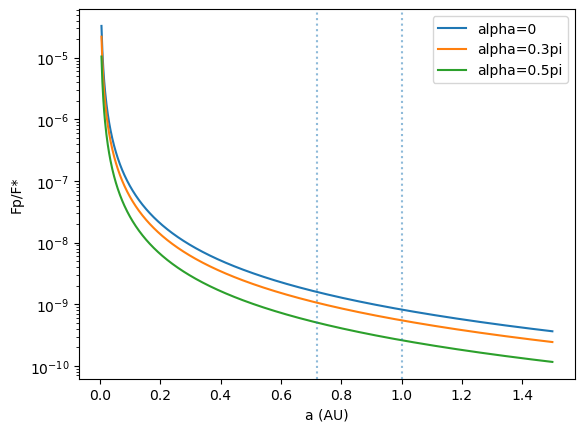

In [31]:
plt.semilogy(a_array, fluxes_alph_0, label='alpha=0')
plt.semilogy(a_array, fluxes_alph_0pt3pi, label='alpha=0.3pi')
plt.semilogy(a_array, fluxes_alph_0pt5pi, label='alpha=0.5pi')
plt.xlabel("a (AU)")
plt.ylabel("Fp/F*")
plt.axvline(x=0.72, linestyle=':', alpha=0.5)
plt.axvline(x=1.0, linestyle=':', alpha=0.5)
plt.legend()
plt.show()

In [14]:
Ag_earth = 0.434 # Jupiter: 0.538; Earth: 0.434
Rp_earth = 0.091 # Jupiter: 1; Earth: 0.091 (approx)
a_earth = 1. # Jupiter: 5.2034; Earth: 1

Ag_jup = 0.538
Rp_jup = 1.
a_jup = 5.2034

ratio_earth = flux_ratio_refl(Ag = Ag_earth, Rp = Rp_earth, a = a_earth, ang_phase=np.pi/2)
ratio_jup = flux_ratio_refl(Ag = Ag_jup, Rp = Rp_jup, a = a_jup, ang_phase=np.pi/2)

In [15]:
print(ratio_earth)
print(ratio_jup)

2.612688039725893e-10
1.4445177855866922e-09


In [8]:
spectrum = get_spectrum(
    T_eff=5800, log_g=4.5, cache=False
)

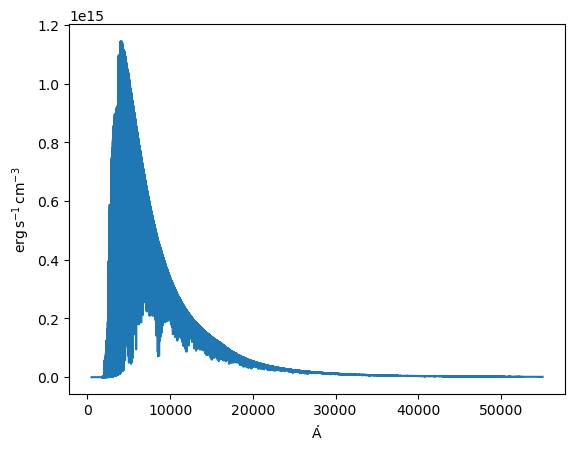

In [10]:
with quantity_support():
    plt.plot(spectrum.wavelength, spectrum.flux)

In [45]:
nulled_planet_snr_array = np.zeros(np.shape(fluxes_alph_0pt3pi))

for i in range(0,len(fluxes_alph_0pt3pi)):
    
    contrast_here = flux_ratio_alph_0pt3pi[i]
    nulled_planet_snr_array[i] = get_photnoise_contrast(del_mag=2, contrast=contrast_here, verbose=True, null_depth=0.3)

Stellar photons: 1.81e+13
S/N of star: 38211684.814890
No-nulling S/N of planet: 92.787297
Nulled S/N of planet: 167.040366
Stellar photons: 1.81e+13
S/N of star: 38211684.814890
No-nulling S/N of planet: 54.962960
Nulled S/N of planet: 98.947089
Stellar photons: 1.81e+13
S/N of star: 38211684.814890
No-nulling S/N of planet: 36.308614
Nulled S/N of planet: 65.364595
Stellar photons: 1.81e+13
S/N of star: 38211684.814890
No-nulling S/N of planet: 25.759821
Nulled S/N of planet: 46.374126
Stellar photons: 1.81e+13
S/N of star: 38211684.814890
No-nulling S/N of planet: 19.219870
Nulled S/N of planet: 34.600578
Stellar photons: 1.81e+13
S/N of star: 38211684.814890
No-nulling S/N of planet: 14.887665
Nulled S/N of planet: 26.801525
Stellar photons: 1.81e+13
S/N of star: 38211684.814890
No-nulling S/N of planet: 11.870735
Nulled S/N of planet: 21.370296
Stellar photons: 1.81e+13
S/N of star: 38211684.814890
No-nulling S/N of planet: 9.685912
Nulled S/N of planet: 17.437067
Stellar photons:

In [38]:
#plt.semilogy(
plt.plot(a_array,nulled_planet_snr_array)
plt.show()

167.0403655760616